In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-3
batch_size = 16
wd = 5e-5
pos_weight = 20
mse_weight = 100  # relative to classification error
image_size = 256
backbone="resnet50"
vertical_type = "axial"
epochs=10

In [3]:
wandb_entity='longyi'
model_name = "detection"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "mse_weight" : mse_weight,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'{vertical_type}_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'axial_segmentation_detection_152607'

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math
from tqdm import tqdm

from PIL import Image, ImageOps

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, f"train_axial_images_jpeg95")
LABEL_DIR = os.path.join(DATA_DIR, f"segmentation_axial_labels")
SAGITTAL_XRAY_DIR = os.path.join(DATA_DIR, f"segmentation_sagittal_xray_labels")
CORONAL_XRAY_DIR = os.path.join(DATA_DIR, "segmentation_coronal_xray_labels")

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, 'segmentation_axial_bbox.csv')).set_index('UID')
print(len(df))
df.tail()

29832


,xmin,ymin,xmax,ymax,aspect,axial_index
UID,,,,,,
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,165
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,166
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,167
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,168
1.2.826.0.1.3680043.9926,103.52358,81.474365,379.6752,330.137,2.844444,169


## Dataset


In [8]:
def square_crop_position(left, top, right, bottom, image_size=512):
    """
    crop box 를 정방형으로 만들어준다. 
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom

square_crop_position(0, 1, 2, 4, image_size=5)

(0, 1, 3, 4)

In [9]:
class SegDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, sagittal_dir, coronal_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.sagittal_dir = sagittal_dir
        self.coronal_dir = coronal_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name

        index = int(s[f"axial_index"])

        slice_img = Image.open(os.path.join(self.image_dir, UID, f"{index}.jpeg"))
        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{index}.png"))

        left, top, right, bottom = s[['xmin','ymin','xmax','ymax']]
        left, top, right, bottom = square_crop_position(left, top, right, bottom)

        slice_img = TF.crop(slice_img, top, left, bottom-top, right-left)
        label_img = TF.crop(label_img, top, left, bottom-top, right-left)

        sagittal = Image.open(os.path.join(self.sagittal_dir, f"{UID}.png"))
        sagittal = np.asarray(sagittal) / 256.
        sagittal_indication = sagittal[int(index * s.aspect) - 1][int(top):int(bottom)]
        sagittal_indication = np.expand_dims(sagittal_indication, axis=1).repeat(len(sagittal_indication), axis=1)
        
        coronal = Image.open(os.path.join(self.coronal_dir, f"{UID}.png"))
        coronal = np.asarray(coronal) / 256.
        coronal_indication = coronal[int(index * s.aspect) - 1][int(left):int(right)]
        coronal_indication = np.expand_dims(coronal_indication, axis=0).repeat(len(coronal_indication), axis=0)

        if self.transform:
            slice_img, label_img, sagittal_indication, coronal_indication = self.transform(slice_img, label_img, sagittal_indication, coronal_indication)

        return slice_img, label_img, sagittal_indication, coronal_indication


358 358


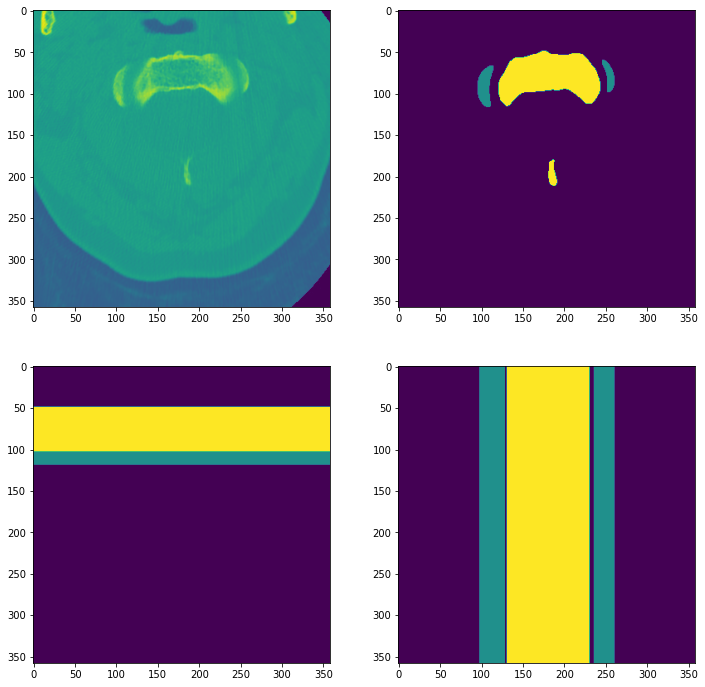

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2)

train_dataset = SegDataset(train_df, IMAGES_DIR, LABEL_DIR, SAGITTAL_XRAY_DIR, CORONAL_XRAY_DIR)

slice, label, sagittal, coronal = train_dataset[200]
print(slice.width, slice.height)
# print(indication.shape)

_, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(slice)
axs[0, 1].imshow(label)
axs[1, 0].imshow(sagittal )
axs[1, 1].imshow(coronal)

## Transform

In [11]:
# aug = A.Compose([
#     A.ShiftScaleRotate(p=1, rotate_limit=45),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Resize(256, 256),
# ])

# augmented = aug(image=np.asarray(slice), masks=[np.asarray(label), np.asarray(indication)])

# image_heavy = augmented['image']
# mask_heavy = augmented['masks']

# _, axs = plt.subplots(1, 3)
# axs[0].imshow(image_heavy)
# axs[1].imshow(mask_heavy[0])
# axs[2].imshow(mask_heavy[1])

torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
tensor(-1.) tensor(0.7725)
tensor(0.) tensor(0.2500)
tensor(0.) tensor(0.2500)


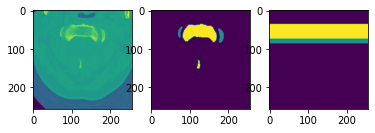

In [12]:
class DataTransform(nn.Module):
    def __init__(self, image_size, train=True):
        super().__init__()

        self.image_size = image_size

        if train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5, rotate_limit=5),
                A.RandomBrightnessContrast(p=0.5),
                A.Resize(image_size, image_size),
                ToTensorV2(p=1),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(image_size, image_size),
                ToTensorV2(p=1),
            ])

        self.normalize = T.Normalize(255 * 0.5, 255 * 0.5)

    def forward(self, x, label, sa, co):
        augmented = self.transform(image=np.asarray(x), masks=[np.asarray(label) / 256., np.asarray(sa), np.asarray(co)])
        x, label, sa, co = augmented['image'],  augmented['masks'][0],  augmented['masks'][1], augmented['masks'][2]

        x = self.normalize(x.float())

        return x, label.unsqueeze(0).float(), sa.unsqueeze(0).float(), co.unsqueeze(0).float()


train_dataset = SegDataset(train_df, IMAGES_DIR, LABEL_DIR, SAGITTAL_XRAY_DIR, CORONAL_XRAY_DIR, DataTransform(image_size))
val_dataset = SegDataset(val_df, IMAGES_DIR, LABEL_DIR, SAGITTAL_XRAY_DIR, CORONAL_XRAY_DIR, DataTransform(image_size, train=False))
slice, label, sa, co = train_dataset[200]
print(slice.shape, label.shape, sa.shape, co.shape)
print(slice.min(), slice.max())
print(label.min(), label.max())
print(sa.min(), sa.max())
_, axs = plt.subplots(1, 3)
axs[0].imshow(slice.squeeze())
axs[1].imshow(label.squeeze())
axs[2].imshow(sa.squeeze())

## Model

In [13]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()
        
        self.mask_module_sa = nn.Parameter(torch.zeros((self.out_channels, 1, 1)), requires_grad=True)
        self.mask_module_co = nn.Parameter(torch.zeros((self.out_channels, 1, 1)), requires_grad=True)
        # self.mask_module2 = nn.Parameter(torch.zeros((self.n_features, 1, 1)), requires_grad=True)

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()
        self.mse_modules = self.make_mse_modules()

    def make_classification_modules(self):
        # the last layer
        # return nn.Sequential(
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(2 * self.out_channels, self.n_features, kernel_size=1, padding='same'),
        # )
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(2 * self.out_channels, 1, kernel_size=1, padding='same'),
        )

    def make_mse_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.out_channels, 2 * self.out_channels, kernel_size=3, padding='same')
            ),
            nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(2 * self.out_channels, 1, kernel_size=1, padding='same'),
            )
        ])
    
    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i], kernel_size=1, padding='same'),
            )
            parallel_modules.append(module)

        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i] // 2, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i] // 2, self.channels[i - 1] if i > 0 else self.out_channels, kernel_size=1),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules

    def forward(self, x, sa, co):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i + 1)]
            parallel_output = parallel_outputs[-(i + 1)]

            up_input = out + parallel_output
            out = module(up_input)

        
        # out = self.classification_modules(out)
        mse_out = out + self.mask_module_sa * sa + self.mask_module_co * co
        mse_out = self.mse_modules[0](mse_out)
        # mse_out += self.mask_module_sa * sa + self.mask_module_co * co
        mse_out = self.mse_modules[1](mse_out)
        
        cla_out = self.classification_modules(out)

        out = torch.cat((cla_out, mse_out), dim=1)
        
        return out

def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

def get_model():
    backbone = resnet50_gray()
    channels = [64, 512, 1024, 2048]
    model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2)
    return model

model = get_model().to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)


# input = torch.randn(2, 1, 256, 256).to(device)
# sa = torch.randn(2, 1, 256, 256).to(device)
# co = torch.randn(2, 1, 256, 256).to(device)
# model(input, sa, co).shape

/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


106921034


In [14]:
def loss_fn(logits, y, pos_weight=1, mse_weight=1):

    classification_logits, mse_score = logits.chunk(2, dim=1)

    classification_y = y.gt(0).float()

    classification_loss = F.binary_cross_entropy_with_logits(classification_logits, classification_y, pos_weight=torch.tensor(pos_weight))

    mse_loss = classification_y * F.mse_loss(mse_score.sigmoid(), y, reduction='none')
    mse_loss = mse_weight * mse_loss.mean()

    return classification_loss, mse_loss

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=min(16, batch_size), drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=min(16, batch_size), drop_last=True)


In [16]:
# x, y, indication = next(iter(train_loader))
#
#
# x = x.to(device)
# y = y.to(device)
# indication = indication.to(device)
#
# model(x, indication).shape

In [17]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [18]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20], gamma=0.5)


In [19]:
def train_one_epoch(e, model, dataloader):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y, sa, co) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)
        sa = sa.to(device)
        co = co.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x, sa, co)
            c_loss, m_loss = loss_fn(logits, y, pos_weight=pos_weight, mse_weight=mse_weight)
            loss = c_loss + m_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # optimizer.step()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {c_loss.item():.4f} m {m_loss.item():.4f}")

        losses.append(loss.item())


        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss' : loss.item(),
                'train_classification_loss' : c_loss.item(),
                'train_mse_loss' : m_loss.item(),
                'epoch' : e,
                'train_iteration' : i + e * epoch_iteration,
                **lr_logs,
            }) 

        if i % 100 == 0:
            with torch.no_grad():
                inference(model, val_dataset)
                # infer_bad_sample(wandb_log=True)
            model.train()

    return np.mean(losses)

In [20]:
@torch.no_grad()
def evaluate(e, model, dataloader):
    model.eval()
    eval_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y, sa, co) in enumerate(eval_iter):
        x = x.to(device)
        y = y.to(device)
        sa = sa.to(device)
        co = co.to(device)

        logits = model(x, sa, co)
        c_loss, m_loss = loss_fn(logits, y)
        loss = c_loss + m_loss

        eval_iter.set_description(f"e {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss': loss.item(),
                'val_classification_loss': c_loss.item(),
                'val_mse_loss': m_loss.item(),
                'epoch': e,
                'val_iteration': i + e * epoch_iteration,
            })

    return np.mean(losses)

In [21]:
def color_image(gray_img, cmap='bone'):
    # 'nipy_spectral'
    cm = plt.get_cmap(cmap)
    colored_image = cm(gray_img)
    return colored_image

In [22]:
@torch.no_grad()
def inference(model, dataset, i_list=None, wandb_log=True):
    model.eval()
    if i_list is None:
        i_list = np.random.choice(len(dataset) - 1, 4)
    x_list = []
    y_list = []
    sa_list = []
    co_list = []
    for i in i_list:
        x, y,sa, co = dataset[i]
        x_list.append(x)
        y_list.append(y)
        sa_list.append(sa)
        co_list.append(co)
    x, y, sa, co = torch.stack(x_list), torch.stack(y_list), torch.stack(sa_list), torch.stack(co_list)

    x = x.to(device)
    sa = sa.to(device)
    co = co.to(device)
    logits = model(x, sa, co)

    classification_logits, mse_score = logits.chunk(2, dim=1)
    classification_pred = classification_logits.sigmoid().gt(0.5).float()
    mse_pred = (classification_pred * mse_score.sigmoid()).squeeze().cpu().numpy()

    img = x * 0.5 + 0.5

    img = color_image(img.squeeze().cpu().numpy())
    classification_pred = color_image(classification_pred.squeeze().cpu().numpy())

    mse_pred = np.round(mse_pred * 8) / 8
    mse_pred = color_image(mse_pred, cmap='nipy_spectral')

    y = color_image(y.squeeze().cpu().numpy(), cmap='nipy_spectral')

    combined_img = np.concatenate((img, classification_pred, mse_pred, y), axis=2)
    combined_img = combined_img.reshape(-1, combined_img.shape[2], combined_img.shape[3])

    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'val_img_pred_label': wandb.Image(combined_img),
        })
    if wandb_log is False:
        plt.imshow(combined_img)
        plt.show()

# with torch.no_grad():
#     inference(model, val_dataset, wandb_log=False)

In [23]:
def infer_sample(model, UIDs, indices, wandb_log=False):
    model.eval()

    x_list = []
    for UID, index in zip(UIDs, indices):
        x, _ = get_inference_input(UID, index, infer_transform)
        x_list.append(x)

    x = torch.stack(x_list)

    x = x.to(device)
    logits = model(x)
    classification_logits, mse_score = logits.chunk(2, dim=1)
    classification_pred = classification_logits.sigmoid().gt(0.5).float()
    mse_pred = (classification_pred * mse_score.sigmoid()).squeeze().cpu().numpy()

    img = x * 0.5 + 0.5

    img = color_image(img.squeeze().cpu().numpy())
    classification_pred = color_image(classification_pred.squeeze().cpu().numpy())

    mse_pred = np.round(mse_pred * 8) / 8
    mse_pred = color_image(mse_pred, cmap='nipy_spectral')

    combined_img = np.concatenate((img, classification_pred, mse_pred), axis=2)

    combined_img = combined_img.reshape(-1, combined_img.shape[2], combined_img.shape[3])

    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'img_pred': wandb.Image(combined_img),
        })
    if wandb_log is False:
        plt.imshow(combined_img)
        plt.show()


@torch.no_grad()
def infer_bad_sample(wandb_log=False):
    sample_UIDs = ["1.2.826.0.1.3680043.16935", "1.2.826.0.1.3680043.32754", "1.2.826.0.1.3680043.575"]
    indices = [247, 252, 326]
    infer_sample(model, sample_UIDs, indices, wandb_log=wandb_log)


# infer_bad_sample()

## Train

In [24]:
with torch.no_grad():
    inference(model, val_dataset)

In [25]:
epoch = 0

In [26]:
for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        evaluate(epoch, model, val_loader)
    # with torch.no_grad():
    #     infer_bad_sample(wandb_log=True)
    # eval_loss = evaluate(epoch, model, val_loader)
    # inference(model, val_dataset)

    # print(f"epoch {epoch} train_loss {train_loss}")

    epoch += 1
    scheduler.step()

t 4 loss 0.0743 c 0.0706 m 0.0037:  18%|█▊        | 262/1491 [01:11<05:36,  3.65it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_169061/1862340680.py", line 3, in <module>
    train_loss = train_one_epoch(epoch, model, train_loader)
  File "/tmp/ipykernel_169061/3683471816.py", line 21, in train_one_epoch
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
  File "/root/miniconda3/lib/python3.8/site-packages/torch/nn/utils/clip_grad.py", line 42, in clip_grad_norm_
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
  File "/root/miniconda3/lib/python3.8/site-packages/torch/nn/utils/clip_grad.py", line 42, in <listcomp>
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
  File "/root/miniconda3/lib/python3.8/site-packages/torch/functional.py", line

TypeError: object of type 'NoneType' has no len()

In [ ]:
# state = {
#     "model": model.state_dict(),
#     "optimizer": optimizer.state_dict(),
#     "scheduler": scheduler.state_dict(),
#     "epoch": epoch,
# }
# torch.save(state, os.path.join(DATA_DIR, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth'))